In [5]:
nlu_csv_path = "nlu_data_csv_mine.csv"
new_data_path = "predicted_labels_round5.csv"
predicted_labels_save ="predicted_labels_round6.csv"

import numpy as np
import csv
from sklearn import datasets
from sklearn.semi_supervised import LabelSpreading
from sklearn.semi_supervised import LabelPropagation
from nltk.corpus import stopwords
from string import punctuation
import spacy
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import preprocessing
LE = preprocessing.LabelEncoder()

nlp = spacy.load('pt')
stemmer = nltk.stem.RSLPStemmer()
stopwords = set(stopwords.words('portuguese') + list(punctuation))
count_vect = CountVectorizer(stop_words=stopwords, ngram_range = (1,2), analyzer = 'word')
tfidf_transformer = TfidfTransformer()

def bag_of_words(Conversas_array):
    X_train = []
    for msg in Conversas_array:
        doc = nlp(str(msg))
        tokens = [token for token in doc]
        filtered_tokens = [token.lemma_ for token in tokens if not token in stopwords]
        X_train.append(TreebankWordDetokenizer().detokenize(filtered_tokens))

    X_train = np.asarray(X_train)
    bag = count_vect.fit_transform(X_train)
    bag_tfidf = tfidf_transformer.fit_transform(bag)
    bag_tfidf = bag_tfidf.toarray()
    return bag_tfidf

def bag_of_words_test(Conversas_array_new):
    X_train_new = []
    for msg in Conversas_array_new:
        doc = nlp(str(msg))
        tokens = [token for token in doc]
        filtered_tokens = [token.lemma_ for token in tokens if not token in stopwords]
        X_train_new.append(TreebankWordDetokenizer().detokenize(filtered_tokens))

    X_train_new = np.asarray(X_train_new)
    bag_new = count_vect.transform(X_train_new)
    bag_tfidf_new = tfidf_transformer.transform(bag_new)    
    bag_tfidf_new = bag_tfidf_new.toarray()
    return bag_tfidf_new

with open(nlu_csv_path) as read_file:
    reader = csv.reader(read_file,delimiter = '\t')
    labels =[]
    Conversas_array = []
    for row in reader:
        labels.append(row[1])
        Conversas_array.append(row[0])
        
        

        
#uncomment for the first label spreading        
'''
with open('out.csv') as read_file:
    reader = csv.reader(read_file, delimiter = '|')
    Conversas_array_new = []
    for row in reader:
        if (row[2]== "  USER") and (row[4].isdigit() == False):
            Conversas_array_new.append(row[4])        
'''

#comment for the first label spreading
with open(new_data_path) as read_file:
    reader = csv.reader(read_file, delimiter = '\t')
    Conversas_array_new = []
    for row in reader:
        
        if (row[3]=="OK"):
            Conversas_array.append(row[0])
            labels.append(row[1])
        else:
            Conversas_array_new.append(row[0])
        

In [6]:
from sklearn.svm import SVC

svm = SVC(gamma='auto', decision_function_shape='ovo')
 

from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

from sklearn.ensemble import RandomForestClassifier

labels = np.asarray(labels)
LE.fit(labels)
labels_enconder = LE.transform(labels)
Conversas_array = np.asarray(Conversas_array)

n_neighors_total = 100
split_count = 1
first_train = True
score = []
for train_index, test_index in kf.split(Conversas_array):
    print("split: %d" %split_count)
    split_count = split_count + 1
    X_train, X_test = Conversas_array[train_index], Conversas_array[test_index]
    y_train, y_test = labels_enconder[train_index], labels_enconder[test_index]
    bag_train = bag_of_words(X_train)
    bag_test = bag_of_words_test(X_test)
    
    '''
    RF = RandomForestClassifier(n_estimators=100)
    RF.fit(bag_train, y_train)
    score.append(RF.score(bag_test, y_test))
    '''
    svm.fit(bag_train, y_train)
    score.append(svm.score(bag_test, y_test))
   
    
    '''
    score = []
    for n in range(1,n_neighors_total+1):
        print("n: %d" %n) 
        label_prop_model = LabelSpreading(n_jobs=-1, kernel = 'knn', n_neighbors=n)
        #label_prop_model = LabelPropagation(n_jobs=-1, kernel = knn)
        label_prop_model.fit(bag_train, y_train)
        score.append(label_prop_model.score(bag_test, y_test))
    for i in range(0, n_neighors_total):
        if (first_train == True):
                mean_score = score
                first_train = False
        else:
            mean_score[i]=mean_score[i]+score[i]
    '''
'''    
for i in range(0, n_neighors_total):
    mean_score[i] = mean_score[i]/10
'''    

split: 1
split: 2
split: 3
split: 4
split: 5
split: 6
split: 7
split: 8
split: 9
split: 10


'    \nfor i in range(0, n_neighors_total):\n    mean_score[i] = mean_score[i]/10\n'

In [7]:
score

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06382978723404255]

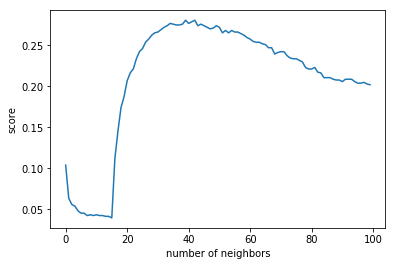

In [38]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(mean_score)
plt.xlabel('number of neighbors')
plt.ylabel('score')
plt.show()

In [32]:
for i in range(0, n_neighors_total):
    mean_score[i] = mean_score[i]*10

In [107]:

labels = np.asarray(labels)
LE.fit(labels)
labels_enconder = LE.transform(labels)

Conversas_array = np.asarray(Conversas_array)
Conversas_array_new = np.asarray(Conversas_array_new)
bag_train = bag_of_words(Conversas_array)
bag_test = bag_of_words_test(Conversas_array_new)
print("bag of words created")

label_prop_model = LabelSpreading(n_jobs=-1, kernel = 'knn', n_neighbors=40)
#label_prop_model = LabelPropagation(n_jobs=-1, kernel = knn)
label_prop_model.fit(bag_train, labels_enconder)
print('model fitted')

predicted_labels = label_prop_model.predict(bag_test)
predicted_labels = LE.inverse_transform(predicted_labels)
predicted_labels_prob = label_prop_model.predict_proba(bag_test)

bag of words created
model fitted


/home/augusto.peterlevitz/repos/ir-sandbox/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [108]:
probs = []
labels_probs = []
with open(predicted_labels_save, "w") as save_file:
    writer = csv.writer(save_file, delimiter = '\t')
    for ordered_index, ordered_label in enumerate(LE.classes_):
        #print(ordered_label)
        for index, label in enumerate(predicted_labels):
            #print(index, label)
            if (ordered_label == label):
                '''
                for row in predicted_labels_prob[index]:
                    high_probs = np.argsort(row)
                '''
                probs.append(predicted_labels_prob[index][ordered_index])
                labels_probs.append(ordered_label)
                #highest_value = max(predicted_labels_prob[index])
                writer.writerow([Conversas_array_new[index], ordered_label, predicted_labels_prob[index][ordered_index]])

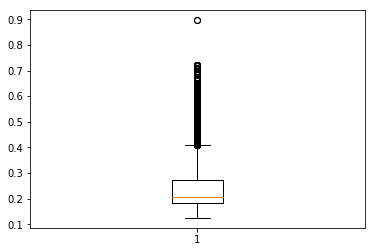

0.2442346926638861


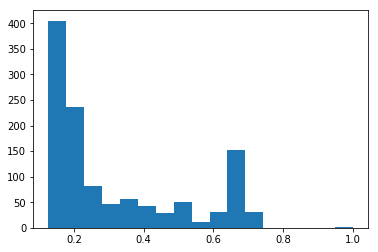

In [110]:
plt.figure()                               
plt.boxplot(probs)
#plt.savefig('bloxplot_%s.png' %round_id)
plt.show()
print(np.mean(probs))

plt.hist(probs_round, bins = "auto")
#plt.savefig('hist_%s.png' %round_id)

plt.show() 

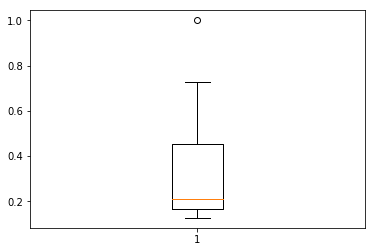

0.3373320545427823


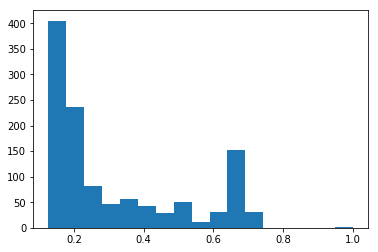

In [94]:
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab

probs_round = []
with open("round2.csv") as read_file:
    reader = csv.reader(read_file, delimiter = '\t')
    for row in reader:
        if (row[3]=="OK"):
            probs_round.append(float(row[2]))

plt.figure()                               
plt.boxplot(probs_round)
#plt.savefig('bloxplot_%s.png' %round_id)
plt.show()
print(np.mean(probs))

plt.hist(probs_round, bins = "auto")
#plt.savefig('hist_%s.png' %round_id)

plt.show()                               

In [ ]:
plt.boxplot(probs_round)
#plt.savefig('bloxplot_%s.png' %round_id)
plt.show()
print(np.mean(probs))

plt.hist(probs_round, bins = "auto")
#plt.savefig('hist_%s.png' %round_id)

plt.show()

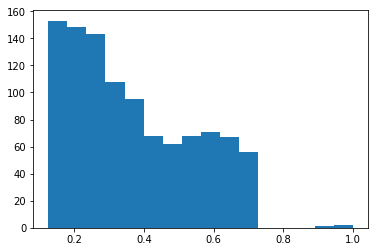

In [59]:
%matplotlib inline 

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
plt.hist(probs, bins = "auto")
plt.savefig('hist_round2.png')

plt.show()

<IPython.core.display.Javascript object>


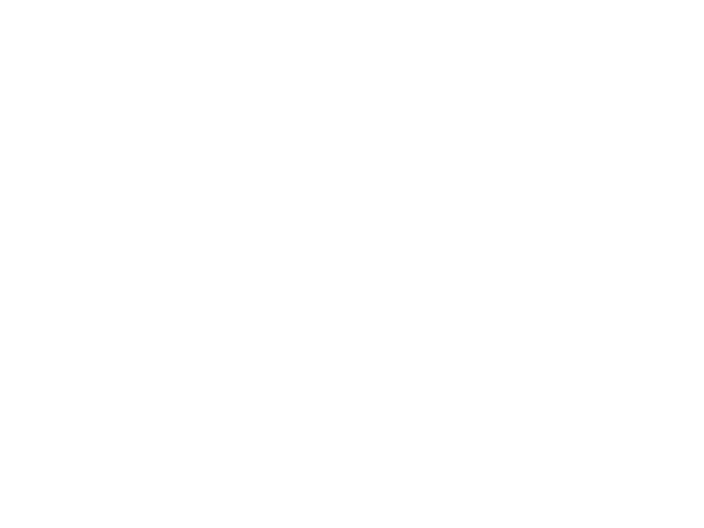

KeyboardInterrupt: 

In [222]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
labels = []
DATA = []

fig, axs = plt.subplots(4, 10)
prev_label = ''
data = []
i = 0
j = 0

labels = []
DATA = []

    
for index, label in enumerate(labels_probs):
    if (label == prev_label):
        data.append(probs[index])
    else:
        DATA.append(data)
        data =[]
        labels.append(label)

axs.boxplot(DATA)
plt.show    

    
'''   
    if (label == prev_label):
        data.append(probs[index])
    else:
        axs[i, j].bloxplot(data)
        axs[i ,j].set_title(label)
        prev_label = label
        data = []
        j = j + 1
        if (j==4):
            i = i + 1
            j = 0
'''       
#plt.show()   

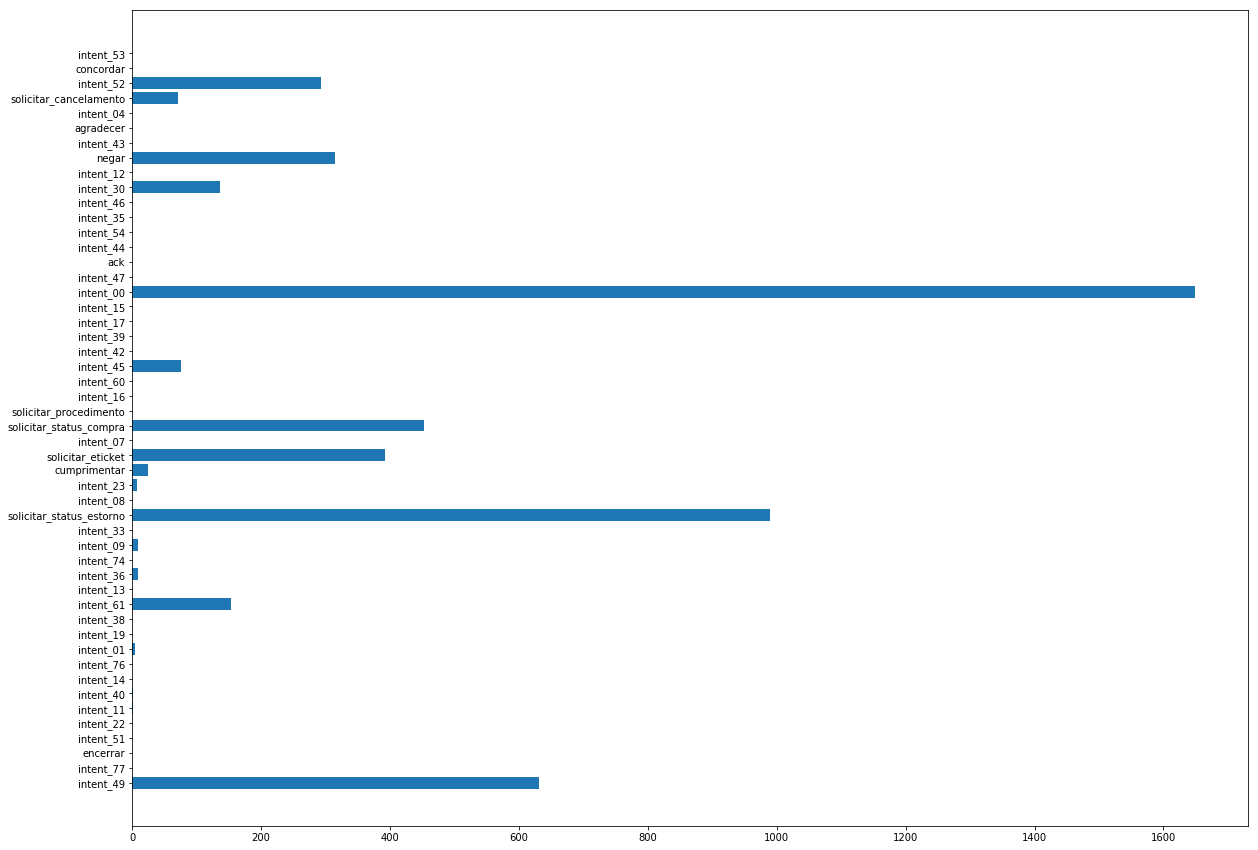

In [4]:
%matplotlib inline
label_dict = {}
msg_list = []
labels_set = list(set(labels))
with open("new_nlu_add.txt", "w") as save_file:
    writer = csv.writer(save_file,delimiter = '\t')
    for label in labels_set:
        writer.writerow([])
        writer.writerow(["## intent:%s" %label])
        count = 0
        with open("round5.csv") as read_file:
            reader = csv.reader(read_file,delimiter = '\t')
            for row in reader:
    
          
                #print(row[1])
                if (label in row[1]) and (row[0] not in msg_list):
                    count = count + 1
                    msg_list.append(row[0])
                    if (row[3]=="OK"):
                        writer.writerow([" - %s" %row[0]])
                #print(count)
                
            label_dict[label] = count
                



import matplotlib.pyplot as plt
 
plt.figure(figsize=(20,15))
plt.barh(range(len(label_dict)), list(label_dict.values()), align='center')
plt.yticks(range(len(label_dict)), list(label_dict.keys()))
plt.savefig('distribuição_intents_round4.png')
plt.show()                                

<IPython.core.display.Javascript object>


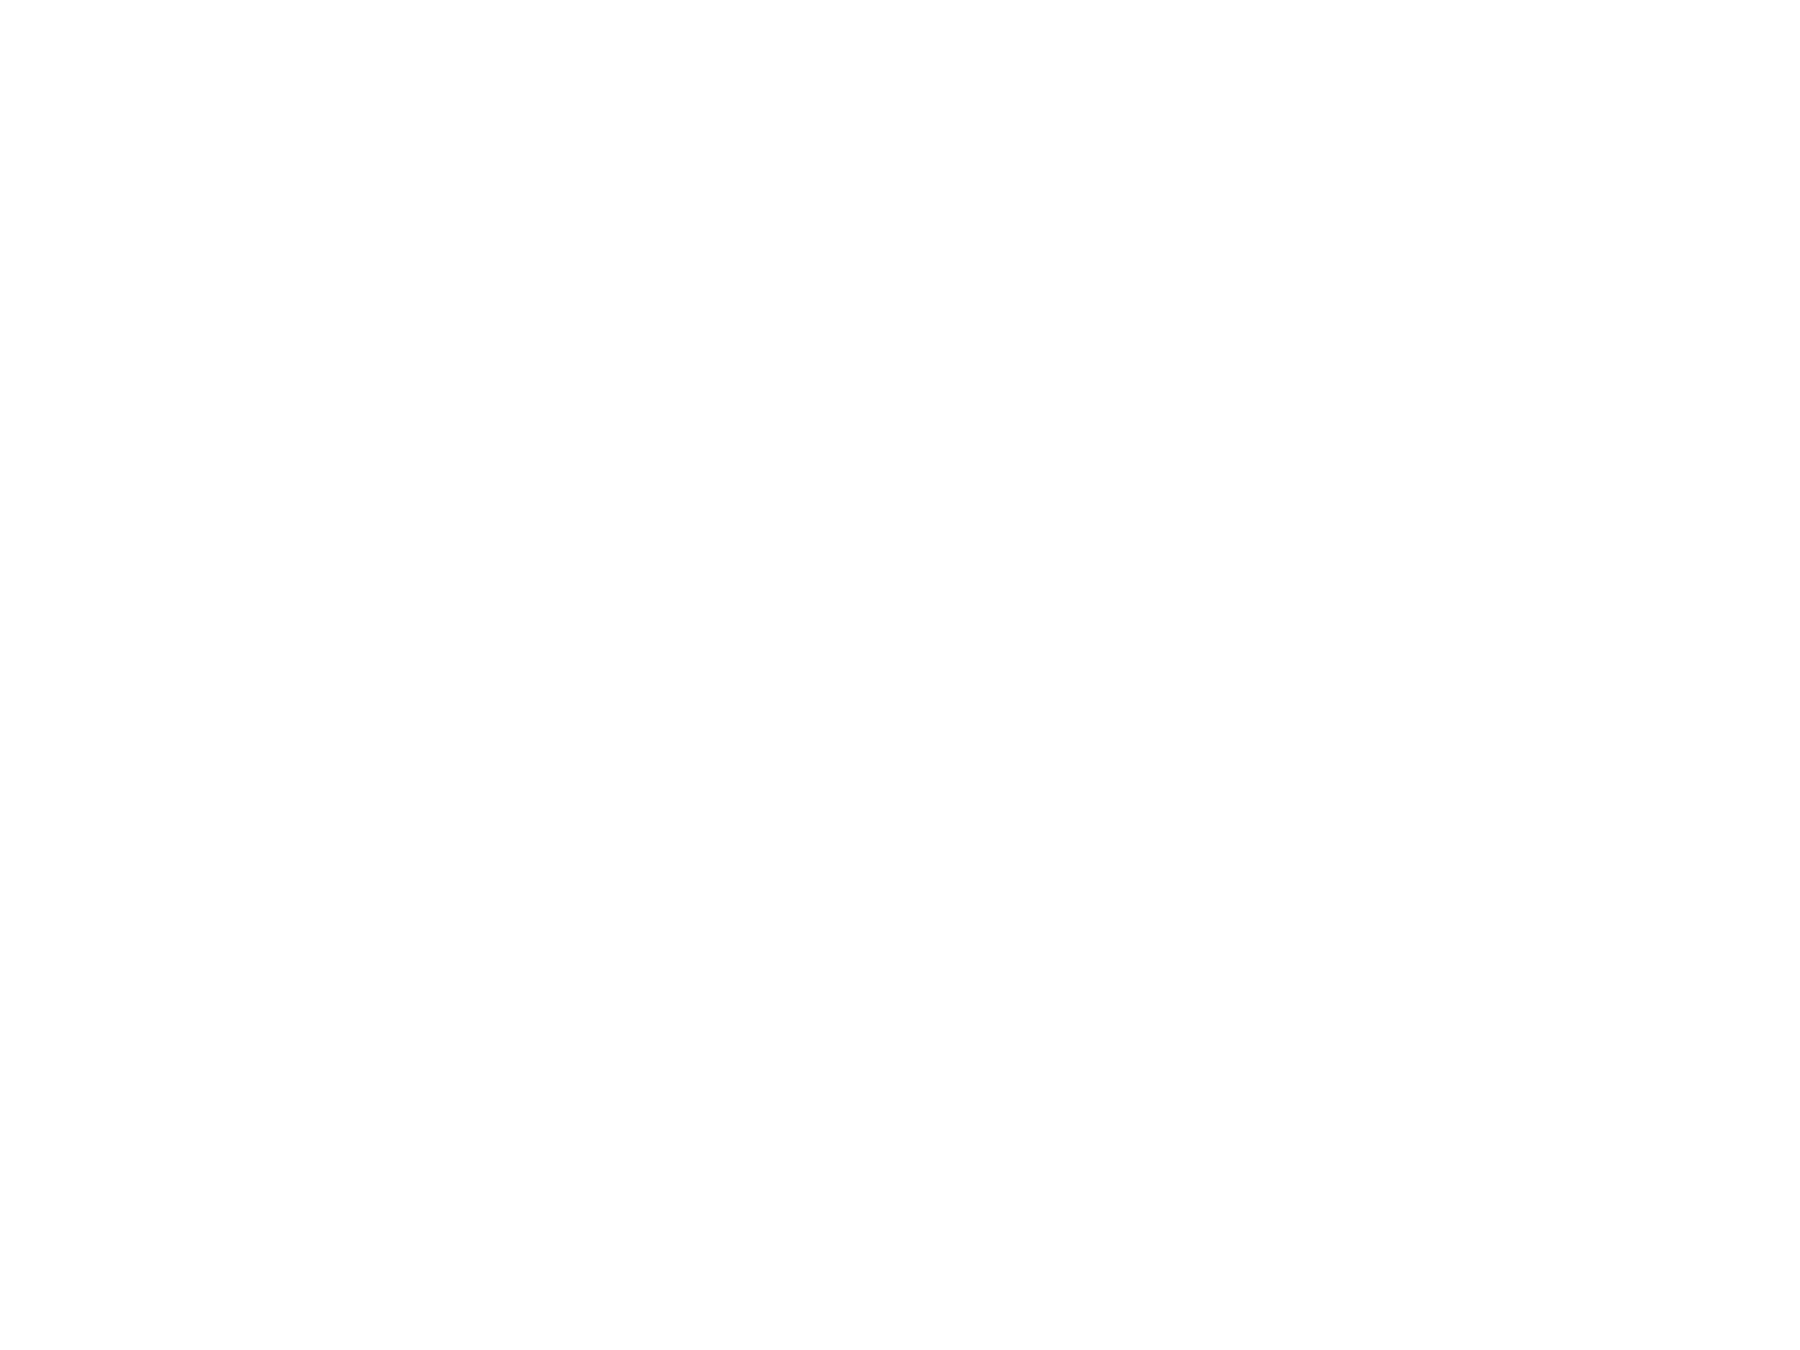

<IPython.core.display.Javascript object>


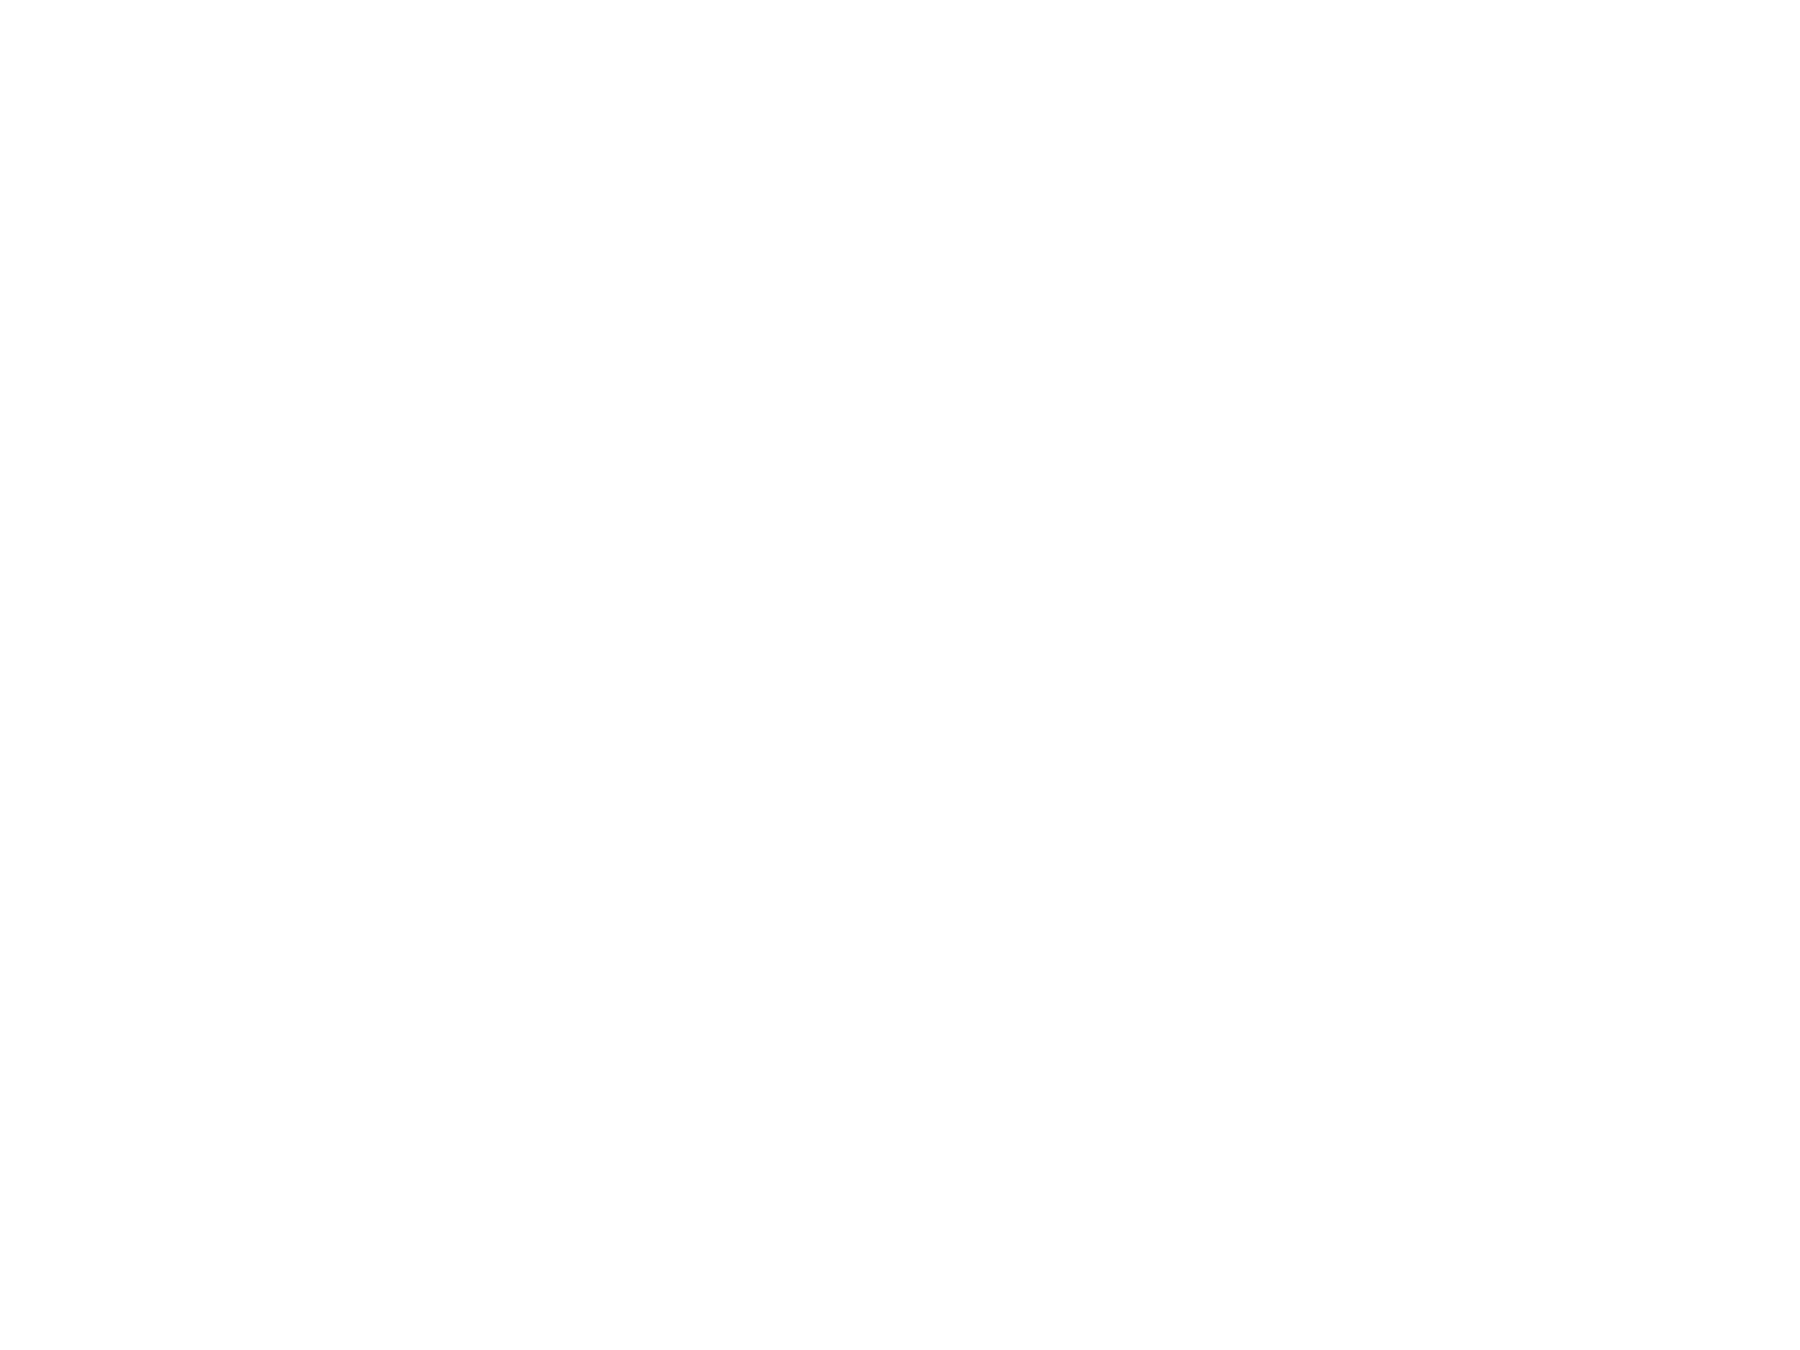

In [13]:
with open("new_nlu.txt", "w") as save_file:
    writer = csv.writer(save_file, delimiter = '\t')
    for msg in msg_list:
        writer.writerow([])

In [ ]:
with open("new_nlu.txt") as read_file:
    reader = csv.reader(read_file, delimiter = '\t')
    for 
    